# Event Time
Event time is an important topic to cover discretely because Spark’s DStream API does not
support processing information with respect to event-time. At a higher level, in streamprocessing
systems there are effectively two relevant times for each event: the time at which it
actually occurred (event time), and the time that it was processed or reached the streamprocessing
system (processing time).
## Event time
Event time is the time that is embedded in the data itself. It is most often, though not required
to be, the time that an event actually occurs. This is important to use because it provides a
more robust way of comparing events against one another. The challenge here is that event
data can be late or out of order. This means that the stream processing system must be able to
handle out-of-order or late data.
## Processing time
Processing time is the time at which the stream-processing system actually receives data.
This is usually less important than event time because when it’s processed is largely an
implementation detail. This can’t ever be out of order because it’s a property of the streaming
system at a certain time (not an external system like event time).

# Stateful Processing
The other topic we need to cover in this chapter is stateful processing. Actually, we already
demonstrated this many times in Chapter 21. Stateful processing is only necessary when you
need to use or update intermediate information (state) over longer periods of time (in either a
microbatch or a record-at-a-time approach). This can happen when you are using event time or
when you are performing an aggregation on a key, whether that involves event time or not.

For the most part, when you’re performing stateful operations. Spark handles all of this
complexity for you. For example, when you specify a grouping, Structured Streaming maintains
and updates the information for you. You simply specify the logic. When performing a stateful
operation, Spark stores the intermediate information in a state store. Spark’s current state store
implementation is an in-memory state store that is made fault tolerant by storing intermediate
state to the checkpoint directory.

## Arbitrary Stateful Processing
The stateful processing capabilities described above are sufficient to solve many streaming
problems. However, there are times when you need fine-grained control over what state should
be stored, how it is updated, and when it should be removed, either explicitly or via a time-out.
This is called arbitrary (or custom) stateful processing and Spark allows you to essentially store
whatever information you like over the course of the processing of a stream. This provides
immense flexibility and power and allows for some complex business logic to be handled quite
easily. Just as we did before, let’s ground this with some examples:
1. You’d like to record information about user sessions on an ecommerce site. For
instance, you might want to track what pages users visit over the course of this session
in order to provide recommendations in real time during their next session. Naturally,
these sessions have completely arbitrary start and stop times that are unique to that user.
2. Your company would like to report on errors in the web application but only if five
events occur during a user’s session. You could do this with count-based windows that
only emit a result if five events of some type occur.
3. You’d like to deduplicate records over time. To do so, you’re going to need to keep
track of every record that you see before deduplicating it.

Now that we’ve explained the core concepts that we’re going to need in this chapter, let’s cover
all of this with some examples that you can follow along with and explain some of the important
caveats that you need to consider when processing in this manner.

# Event-Time Basics
Let’s begin with the same dataset from the previous chapter. When working with event time, it’s
just another column in our dataset, and that’s really all we need to concern ourselves with; we
simply use that column, as demonstrated here:

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [5]:
spark.conf.set("spark.sql.shuffle.partitions", 5)
static = spark.read.json("../data/activity-data")
streaming = spark\
.readStream\
.schema(static.schema)\
.option("maxFilesPerTrigger", 10)\
.json("../data/activity-data")
streaming.printSchema()

root
 |-- Arrival_Time: long (nullable = true)
 |-- Creation_Time: long (nullable = true)
 |-- Device: string (nullable = true)
 |-- Index: long (nullable = true)
 |-- Model: string (nullable = true)
 |-- User: string (nullable = true)
 |-- gt: string (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



In this dataset, there are two time-based columns. The Creation_Time column defines when an
event was created, whereas the Arrival_Time defines when an event hit our servers somewhere
upstream. We will use Creation_Time in this chapter. This example reads from a file but, as we
saw in the previous chapter, it would be simple to change it to Kafka if you already have a
cluster up and running.
## Windows on Event Time
The first step in event-time analysis is to convert the timestamp column into the proper Spark
SQL timestamp type. Our current column is unixtime nanoseconds (represented as a long),
therefore we’re going to have to do a little manipulation to get it into the proper format:

In [14]:
withEventTime = streaming.selectExpr("*",\
"cast(cast(Creation_Time as double)/1000000000 as timestamp) as event_time")

We’re now prepared to do arbitrary operations on event time! Note how this experience is just
like we’d do in batch operations—there’s no special API or DSL. We simply use columns, just
like we might in batch, the aggregation, and we’re working with event time.

## Tumbling Windows
The simplest operation is simply to count the number of occurrences of an event in a given
window. Figure 22-2 depicts the process when performing a simple summation based on the
input data and a key.
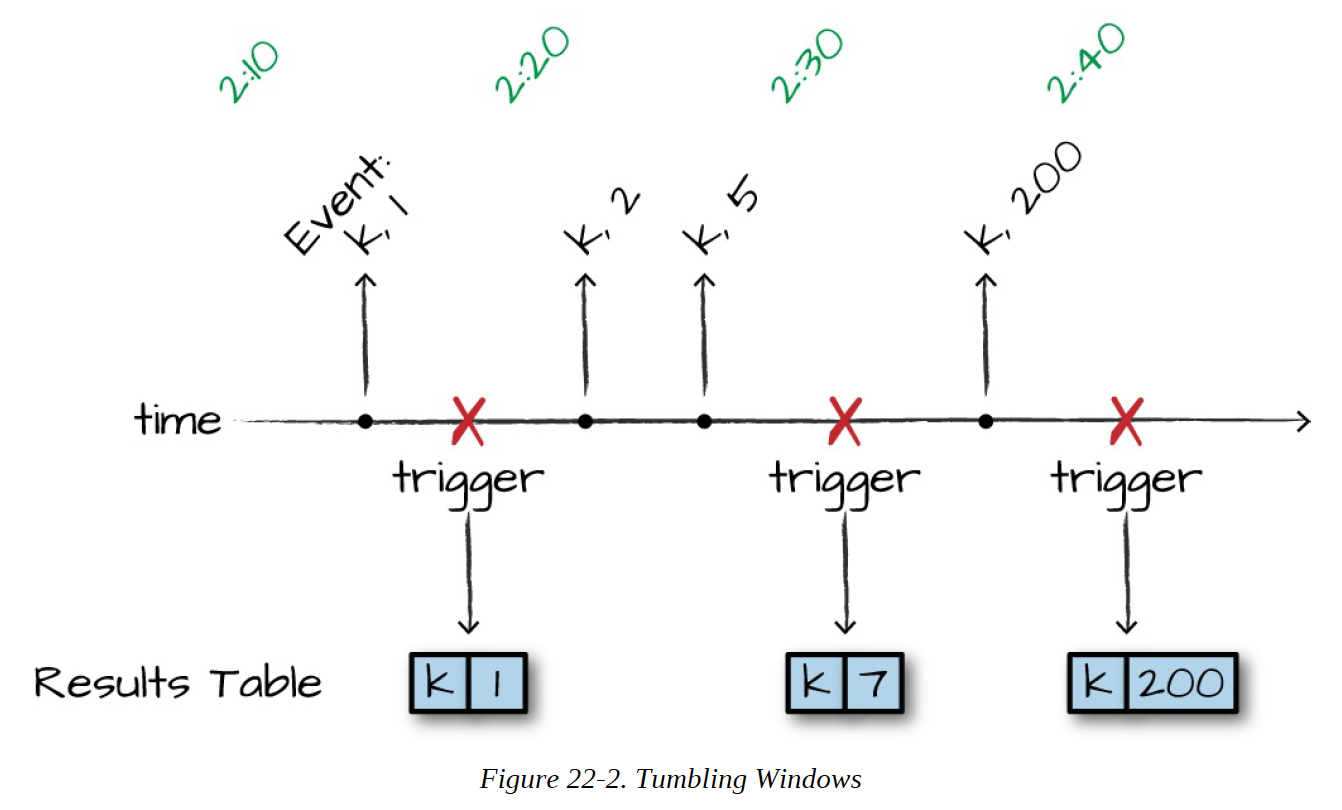
We’re performing an aggregation of keys over a window of time. We update the result table
(depending on the output mode) when every trigger runs, which will operate on the data received
since the last trigger. In the case of our actual dataset (and Figure 22-2), we’ll do so in 10-minute
windows without any overlap between them (each, and only one event can fall into one window).
This will update in real time, as well, meaning that if new events were being added upstream to
our system, Structured Streaming would update those counts accordingly. This is the complete
output mode, Spark will output the entire result table regardless of whether we’ve seen the entire
dataset:

In [17]:
from pyspark.sql.functions import window, col
withEventTime.groupBy(window(col("event_time"), "10 minutes")).count()\
.writeStream\
.queryName("events_per_window")\
.format("memory")\
.outputMode("complete")\
.start()

Now we’re writing out to the in-memory sink for debugging, so we can query it with SQL after
we have the stream running:

In [18]:
spark.sql("SELECT * FROM events_per_window").printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- count: long (nullable = false)



In [19]:
spark.sql("SELECT * FROM events_per_window").show(4)

+--------------------+------+
|              window| count|
+--------------------+------+
|[2015-02-24 11:50...|150773|
|[2015-02-24 13:00...|133323|
|[2015-02-23 12:30...|100853|
|[2015-02-23 10:20...| 99178|
+--------------------+------+
only showing top 4 rows



Notice how window is actually a struct (a complex type). Using this we can query this struct
for the start and end times of a particular window.
Of importance is the fact that we can also perform an aggregation on multiple columns, including
the event time column. Just like we saw in the previous chapter, we can even perform these
aggregations using methods like cube. While we won’t repeat the fact that we can perform the
multi-key aggregation below, this does apply to any window-style aggregation (or stateful
computation) we would like:

In [22]:
from pyspark.sql.functions import window, col
withEventTime.groupBy(window(col("event_time"), "10 minutes"), "User").count()\
.writeStream\
.queryName("events_per_window_2")\
.format("memory")\
.outputMode("complete")\
.start()

## Sliding windows
The previous example was simple counts in a given window. Another approach is that we can
decouple the window from the starting time of the window. Figure 22-3 illustrates what we
mean.
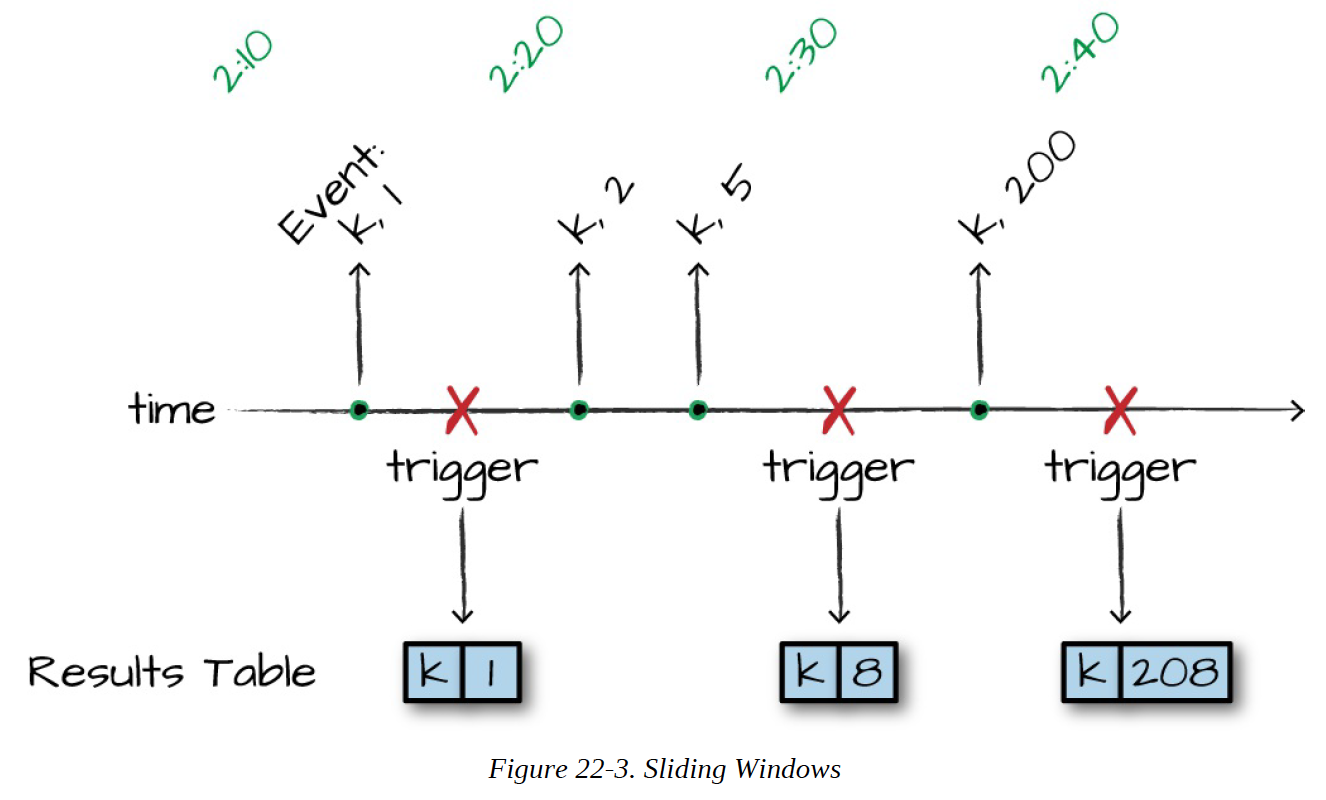
In the figure, we are running a sliding window through which we look at an hour increment, but
we’d like to get the state every 10 minutes. This means that we will update the values over time
and will include the last hours of data. In this example, we have 10-minute windows, starting
every five minutes. Therefore each event will fall into two different windows. You can tweak
this further according to your needs:

In [24]:
from pyspark.sql.functions import window, col
withEventTime.groupBy(window(col("event_time"), "10 minutes", "5 minutes"))\
.count()\
.writeStream\
.queryName("events_per_window_3")\
.format("memory")\
.outputMode("complete")\
.start()

Naturally, we can query the in-memory table:

In [25]:
# SELECT * FROM events_per_window

### Handling Late Data with Watermarks
The preceding examples are great, but they have a flaw. We never specified how late we expect
to see data. This means that Spark is going to need to store that intermediate data forever because
we never specified a watermark, or a time at which we don’t expect to see any more data. This
applies to all stateful processing that operates on event time. We must specify this watermark in
order to age-out data in the stream (and, therefore, state) so that we don’t overwhelm the system
over a long period of time.

Concretely, a watermark is an amount of time following a given event or set of events after
which we do not expect to see any more data from that time.

In [27]:
from pyspark.sql.functions import window, col
withEventTime\
.withWatermark("event_time", "30 minutes")\
.groupBy(window(col("event_time"), "10 minutes", "5 minutes"))\
.count()\
.writeStream\
.queryName("events_per_window_4")\
.format("memory")\
.outputMode("complete")\
.start()

It’s pretty amazing, but almost nothing changed about our query. We essentially just added
another configuration. Now, Structured Streaming will wait until 30 minutes after the final
timestamp of this 10-minute rolling window before it finalizes the result of that window. We can
query our table and see the intermediate results because we’re using complete mode—they’ll be
updated over time. In append mode, this information won’t be output until the window closes.

At this point, you really know all that you need to know about handling late data. Spark does all
of the heavy lifting for you. Just to reinforce the point, if you do not specify how late you think
you will see data, then Spark will maintain that data in memory forever. Specifying a watermark
allows it to free those objects from memory, allowing your stream to continue running for a long
time.

# Dropping Duplicates in a Stream
One of the more difficult operations in record-at-a-time systems is removing duplicates from the
stream. Almost by definition, you must operate on a batch of records at a time in order to find
duplicates—there’s a high coordination overhead in the processing system. Deduplication is an
important tool in many applications, especially when messages might be delivered multiple times
by upstream systems. A perfect example of this are Internet of Things (IoT) applications that
have upstream producers generating messages in nonstable network environments, and the same
message might end up being sent multiple times. Your downstream applications and
aggregations should be able to assume that there is only one of each message.

Essentially, Structured Streaming makes it easy to take message systems that provide at-leastonce
semantics, and convert them into exactly-once by dropping duplicate messages as they
come in, based on arbitrary keys. To de-duplicate data, Spark will maintain a number of user
specified keys and ensure that duplicates are ignored.

## WARNING
Just like other stateful processing applications, you need to specify a watermark to ensure that the
maintained state does not grow infinitely over the course of your stream.

Let’s begin the de-duplication process. The goal here will be to de-duplicate the number of
events per user by removing duplicate events. Notice how you need to specify the event time
column as a duplicate column along with the column you should de-duplicate. The core
assumption is that duplicate events will have the same timestamp as well as identifier. In this
model, rows with two different timestamps are two different records:

In [28]:
from pyspark.sql.functions import expr
withEventTime\
.withWatermark("event_time", "5 seconds")\
.dropDuplicates(["User", "event_time"])\
.groupBy("User")\
.count()\
.writeStream\
.queryName("pydeduplicated")\
.format("memory")\
.outputMode("complete")\
.start()

In [29]:
spark.sql('SELECT * FROM pydeduplicated').show(2)

+----+-----+
|User|count|
+----+-----+
|   a|80854|
|   b|91239|
+----+-----+
only showing top 2 rows



# Arbitrary Stateful Processing
Stateful processing is available only in Scala in Spark 2.2. This
will likely change in the future.
1. When performing stateful processing, you might want to do the following:
Create window based on counts of a given key
2. Emit an alert if there is a number of events within a certain time frame
3. Maintain user sessions of an undetermined amount of time and save those sessions to
perform some analysis on later.

At the end of the day, there are two things you will want to do when performing this style of
processing:

1. Map over groups in your data, operate on each group of data, and generate at most a
single row for each group. The relevant API for this use case is mapGroupsWithState.
2. Map over groups in your data, operate on each group of data, and generate one or more
rows for each group. The relevant API for this use case is flatMapGroupsWithState.

When we say “operate” on each group of data, that means that you can arbitrarily update each
group independent of any other group of data. This means that you can define arbitrary window
types that don’t conform to tumbling or sliding windows like we saw previously in the chapter.
One important benefit that we get when we perform this style of processing is control over
configuring time-outs on state. With windows and watermarks, it’s very simple: you simply
time-out a window when the watermark passes the window start. This doesn’t apply to arbitrary
stateful processing, because you manage the state based on user-defined concepts. Therefore,
you need to properly time-out your state. Let’s discuss this a bit more.

## Time-Outs
As mentioned in Chapter 21, a time-out specifies how long you should wait before timing-out
some intermediate state. A time-out is a global parameter across all groups that is configured on
a per-group basis. Time-outs can be either based on processing time
(GroupStateTimeout.ProcessingTimeTimeout) or event time
(GroupStateTimeout.EventTimeTimeout). When using time-outs, check for time-out first
before processing the values. You can get this information by checking the state.hasTimedOut
flag or checking whether the values iterator is empty. You need to set some state (i.e., state must
be defined, not removed) for time-outs to be set.

With a time-out based on processing time, you can set the time-out duration by calling
GroupState.setTimeoutDuration (we’ll see code examples of this later in this section of the
chapter). The time-out will occur when the clock has advanced by the set duration. Guarantees
provided by this time-out with a duration of D ms are as follows:
1. Time-out will never occur before the clock time has advanced by D ms
2. Time-out will occur eventually when there is a trigger in the query (i.e., after D ms). So
there is a no strict upper bound on when the time-out would occur. For example, the
trigger interval of the query will affect when the time-out actually occurs. If there is no
data in the stream (for any group) for a while, there won’t be any trigger and the timeout
function call will not occur until there is data.